Installing adversarial-robustness-toolbox comes first...

*If you have a failure on KAPRE package, do not worry (it is for audio pre-processing)*

In [1]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.13.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


#Create and inject adversarial attacks

Same model on TSC seen in previous lecture. But now we use it to inject attacks!

First of all, we have the imports, dataset and model as before

In [2]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.misc
#import PIL
import matplotlib
import matplotlib.pyplot as plt
import skimage.data
import skimage.transform
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import random
import os
from skimage import io
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from keras.optimizers import Adam # con TPU usare Adam normale, senza TPU usare la versione legacy
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from skimage import transform
from skimage import exposure
from skimage import io

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/ColabDCML/'
my_root_path = 'gdrive/My Drive/DCML-CPS/'

Mounted at /content/gdrive


In [4]:
data_root=root_path+'/datasets/BelgiumDataset-Truncated/' #SHORTENED VERSION OF THE TESTING SET
test_data_dir=data_root+'/Testing/'

In [5]:
#load the test data
def load_data(data_dir):
    """Loads a data set and returns two lists:
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir)
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        #print(d)
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f)
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load its images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(io.imread(f))
            labels.append(int(d))
    return images, labels

In [6]:
#load the model
class TrafficSignNet:

	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (32, 32, 3)
		chanDim = -1
		# CONV => RELU => BN => POOL
		model.add(Conv2D(8, (5, 5), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		# first set of (CONV => RELU => CONV => RELU) * 2 => POOL
		model.add(Conv2D(16, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(16, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		# second set of (CONV => RELU => CONV => RELU) * 2 => POOL
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		# first set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
		# second set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))
		# return the constructed network architecture
		return model

In [7]:
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
  validation_split=0.2,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")

# initialize the optimizer and compile the model
print("[INFO] compiling model...")
INIT_LR=0.001
NUM_EPOCHS=50
numLabels=62
BS=128
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))

model = TrafficSignNet.build(width=32, height=32, depth=3, classes=numLabels)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


Instructions for updating:
Colocations handled automatically by placer.


In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

cb=EarlyStopping(monitor='loss', mode='min', patience=3) # to stop after 3 times loss does not improve

checkpoint_path = root_path+"3-Adversarial attacks/checkpoint"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_freq="epoch", #every epoch we save checkpoints
                                                 save_weights_only=True, verbose=1)

cb_list = [cb, cp_callback]

In [9]:
model.load_weights(checkpoint_path) #SET PATH TO CHECKPOINT

In [10]:
t_images, t_labels = load_data(test_data_dir)

In [11]:
# Transform the images, just like we did with the training set.
test_images = [skimage.transform.resize(image, (32, 32), mode='constant')
                 for image in t_images]
#display_images_and_labels(test_images32, test_labels)
test_labels = np.array(t_labels) #TEST IMAGES
test_images = np.array(test_images) # LABELS

In [ ]:
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
loss, acc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


(0.378529308018861, 0.8703704)

# Attack example: Fast Gradient Method

As example, we consider the attack FGM

**Imports required for the Fast Gradient Method attack**

**Create the ART classifier**

We need to instantiate the Keras Classifier. Its signature is rather complex

```
class art.estimators.classification.KerasClassifier(
model: Union[keras.models.Model, tf.keras.models.Model],
use_logits: bool = False,
channels_first: bool = False,
clip_values: Optional[CLIP_VALUES_TYPE] = None,
preprocessing_defences: Optional[Union[Preprocessor, List[Preprocessor]]] = None,
postprocessing_defences: Optional[Union[Postprocessor, List[Postprocessor]]] = None,
preprocessing: PREPROCESSING_TYPE = (0.0, 1.0),
input_layer: int = 0,
output_layer: int = 0)
```
but we just need:
```
class art.estimators.classification.KerasClassifier(
model: Union[keras.models.Model, tf.keras.models.Model],
clip_values: Optional[CLIP_VALUES_TYPE] = None)
```





So, first we get the *clip_values*. According to the API, they are:

"*Tuple of the form (min, max) of floats or np.ndarray representing the minimum and maximum values allowed for features*."

In our case, we just need to get the min and max value of pixels of our image: (0, 255) or (0, 1)

In [ ]:
test_images[0]
# and from the output you can see that our limits are 0.0, 1.0

array([[[0.21886488, 0.22086434, 0.13916154],
        [0.22199859, 0.19339559, 0.14210099],
        [0.31344311, 0.25858176, 0.20336956],
        ...,
        [0.31760417, 0.29383324, 0.2699785 ],
        [0.39598768, 0.38657008, 0.37300459],
        [0.30669433, 0.30617259, 0.29048817]],

       [[0.25512842, 0.21005926, 0.14136311],
        [0.28093264, 0.25112196, 0.19107031],
        [0.32489721, 0.28661193, 0.22783894],
        ...,
        [0.34582972, 0.32134597, 0.26085035],
        [0.44798634, 0.43070239, 0.38815439],
        [0.40342083, 0.4233356 , 0.40728762]],

       [[0.29257959, 0.27780436, 0.17089768],
        [0.21320372, 0.21198392, 0.13703002],
        [0.22314553, 0.20337163, 0.14251617],
        ...,
        [0.29177845, 0.28035994, 0.22624324],
        [0.34595718, 0.30563856, 0.26249752],
        [0.32883143, 0.30830034, 0.25347105]],

       ...,

       [[0.19655615, 0.15365511, 0.1154694 ],
        [0.2458702 , 0.20280216, 0.14325517],
        [0.28131075, 0

At this point, we can instantiate the classifier requested by the ART toolbox, it is as easy as:

In [ ]:
classifier = KerasClassifier(model=model, clip_values=(0.0, 1.0))

We test the classifier on clean images. We have an utility of the ART Toolbox for this.

In [ ]:
predictions = classifier.predict(test_images)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


What are "predictions"?

In [ ]:
predictions.shape

(108, 62)

In [ ]:
predictions

array([[9.2776958e-10, 1.5723333e-09, 2.8359359e-09, ..., 8.1216411e-09,
        3.0209424e-04, 9.9968255e-01],
       [4.6794690e-10, 4.0597736e-10, 5.1192767e-10, ..., 8.3700859e-11,
        2.8605229e-05, 9.9997109e-01],
       [2.9512526e-06, 3.8342914e-06, 3.7284135e-06, ..., 5.6341196e-06,
        4.9548140e-01, 4.3742472e-01],
       ...,
       [1.6317276e-04, 2.1605470e-06, 2.3676108e-03, ..., 1.1418028e-07,
        1.2535581e-06, 8.7925542e-07],
       [6.1373453e-07, 1.9082408e-06, 4.6718479e-03, ..., 8.7794220e-08,
        7.9293841e-08, 2.7816817e-08],
       [3.3878308e-04, 1.6775370e-03, 6.0263958e-02, ..., 5.1531326e-05,
        1.1594569e-06, 2.1776132e-06]], dtype=float32)

In [ ]:
np.argmax(predictions, axis=1)


array([61, 61, 60, 61, 58, 59, 59, 57, 56, 56, 55, 55, 53, 53, 47, 47, 47,
       45, 46, 51, 51, 54, 54, 49, 47, 41, 41, 44, 44, 43, 43, 45, 45, 42,
       42, 42, 40, 40, 34, 39, 37, 37, 38, 38, 34, 34, 35, 35, 32, 32, 31,
       31, 30, 30, 32, 29, 24, 24, 28, 28, 24, 27, 23, 28, 25, 25, 22, 22,
       21, 21, 20, 20, 19, 19, 18, 18, 14, 14, 14, 14, 17, 17, 13, 13,  8,
        8, 10, 10,  9,  5,  7,  5,  6,  2,  0,  0,  1,  1,  4,  4,  7,  7,
        7,  7,  6,  6,  3,  3])

In [ ]:
tf.keras.utils.to_categorical(np.argmax(predictions, axis=1))

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Let's see results. We just need to compare predictions with test_labels.

In [ ]:
test_labels

array([61, 61, 60, 60, 58, 59, 59, 57, 56, 56, 55, 55, 53, 53, 47, 47, 47,
       46, 46, 51, 51, 54, 54, 49, 49, 41, 41, 44, 44, 43, 43, 45, 45, 42,
       42, 42, 40, 40, 39, 39, 37, 37, 38, 38, 34, 34, 35, 35, 32, 32, 31,
       31, 30, 30, 29, 29, 24, 24, 28, 28, 27, 27, 23, 23, 25, 25, 22, 22,
       21, 21, 20, 20, 19, 19, 18, 18, 14, 14, 16, 16, 17, 17, 13, 13,  8,
        8, 10, 10, 12, 12,  5,  5,  2,  2,  0,  0,  1,  1,  4,  4,  7,  7,
        7,  6,  6,  6,  3,  3])

the following just shows that test_labels and predictions can be compared to compute accuracy of categories

In [ ]:
tf.keras.utils.to_categorical(test_labels, num_classes=62, dtype="int32")

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

We compute accuracy.

In [ ]:
accuracy = np.sum(np.argmax(predictions, axis=1) == test_labels) / test_labels.shape[0]

In [ ]:
accuracy

0.8703703703703703

The ART KerasClassifier (Keras wrapper) works nicely, as the model loaded with Keras! We get the same accuracy.

Now we try on a single image and we inject attacks.


Select an image (variable **IMAGE_NUMBER**), apply prediction and compute accuracy on clean image

In [ ]:
IMAGE_NUMBER=3 #just choose a number
predictions = classifier.predict([test_images[IMAGE_NUMBER]]) #note the [test_image[number]]
accuracy = np.sum(np.argmax(predictions, axis=1) == [test_labels[IMAGE_NUMBER]]) / 1.0 # we have only 1 image this time

In [ ]:
accuracy #should be 100%, otherwise select another image

1.0

In [ ]:
print(predictions.shape) #shape
print(np.argmax(predictions, axis=1)) # predicted image class, i.e., higher value
print(predictions[0][np.argmax(predictions, axis=1)]) #the higher value of the output layer
predictions # whole list of predictions, for all the classes

(1, 62)
[59]
[0.9998217]


array([[1.4752362e-07, 1.6998969e-05, 1.9971131e-08, 1.4695681e-08,
        5.1140325e-10, 3.1058168e-08, 1.0333843e-09, 1.1697076e-09,
        3.3625405e-08, 1.2241346e-06, 7.6828288e-10, 3.4312637e-07,
        1.1109424e-07, 2.3479913e-08, 1.0928337e-09, 4.6591628e-09,
        5.3533711e-10, 5.4674393e-10, 7.7676410e-10, 6.6973831e-12,
        6.3644440e-10, 5.4536674e-11, 1.4183730e-07, 7.9554675e-11,
        8.6114111e-12, 5.9706140e-10, 3.2425014e-11, 1.8441506e-09,
        2.5606672e-09, 1.4635853e-11, 3.6570431e-11, 1.4673806e-08,
        9.5373405e-13, 2.6048917e-07, 2.2665633e-08, 2.6952762e-06,
        4.3030255e-09, 4.5169006e-09, 2.3853697e-06, 2.4849119e-06,
        6.6433003e-08, 1.6541695e-07, 3.5722358e-09, 7.9083335e-09,
        1.2683478e-09, 7.4614634e-11, 1.0813689e-10, 5.3833037e-07,
        3.9030862e-08, 2.5747698e-07, 1.0067732e-09, 3.5126084e-06,
        1.4229763e-06, 1.3848223e-08, 9.4619321e-07, 1.6728777e-06,
        1.3927996e-04, 3.3956717e-06, 1.9734317e

We sort the predictions value, and the corresponding predicted classes, with sort and argsort.

In [ ]:
np.sort(predictions), np.argsort(predictions)

(array([[9.5373405e-13, 6.6973831e-12, 8.6114111e-12, 1.4635853e-11,
         3.2425014e-11, 3.6570431e-11, 5.4536674e-11, 7.4614634e-11,
         7.9554675e-11, 1.0813689e-10, 2.6619501e-10, 5.1140325e-10,
         5.3533711e-10, 5.4674393e-10, 5.9706140e-10, 6.3644440e-10,
         7.2253936e-10, 7.6828288e-10, 7.7676410e-10, 1.0067732e-09,
         1.0333843e-09, 1.0928337e-09, 1.1697076e-09, 1.2683478e-09,
         1.8441506e-09, 2.5606672e-09, 3.5722358e-09, 4.3030255e-09,
         4.5169006e-09, 4.6591628e-09, 7.9083335e-09, 1.3848223e-08,
         1.4673806e-08, 1.4695681e-08, 1.9734317e-08, 1.9971131e-08,
         2.2665633e-08, 2.3479913e-08, 3.1058168e-08, 3.3625405e-08,
         3.9030862e-08, 6.6433003e-08, 1.1109424e-07, 1.4183730e-07,
         1.4752362e-07, 1.6541695e-07, 2.5747698e-07, 2.6048917e-07,
         3.4312637e-07, 5.3833037e-07, 9.4619321e-07, 1.2241346e-06,
         1.4229763e-06, 1.6728777e-06, 2.3853697e-06, 2.4849119e-06,
         2.6952762e-06, 3.3956717e

Finally, we try with the attack **Fast Gradient Method**

We load the attack and apply on our selected image.

Check the definition of the attack API:

https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#fast-gradient-method-fgm

In [ ]:
#class art.attacks.evasion.FastGradientMethod
#(estimator: CLASSIFIER_LOSS_GRADIENTS_TYPE,
#norm: Union[int, float, str] = inf,
#eps: Union[int, float, numpy.ndarray] = 0.3,
#eps_step: Union[int, float, numpy.ndarray] = 0.1,
#targeted: bool = False, num_random_init: int = 0,
#batch_size: int = 32, minimal: bool = False,
#tensor_board: Union[str, bool] = False)

# estimator – A trained classifier.
# norm – The norm of the adversarial perturbation. Possible values: “inf”, np.inf, 1 or 2.
# eps – Attack step size (input variation).
# eps_step – Step size of input variation for minimal perturbation computation.
# targeted (bool) – Indicates whether the attack is targeted (True) or untargeted (False)
# num_random_init (int) – Number of random initialisations within the epsilon ball. For random_init=0 starting at the original input.
# batch_size (int) – Size of the batch on which adversarial samples are generated.
# minimal (bool) – Indicates if computing the minimal perturbation (True). If True, also define eps_step for the step size and eps for the maximum perturbation.
# tensor_board – Activate summary writer for TensorBoard: Default is False and deactivated summary writer. If True save runs/CURRENT_DATETIME_HOSTNAME in current directory. Provide path in type str to save in path/CURRENT_DATETIME_HOSTNAME. Use hierarchical folder structure to compare between runs easily. e.g. pass in ‘runs/exp1’, ‘runs/exp2’, etc. for each new experiment to compare across them.

#LOAD THE ATTACK LIBRARY
attack = FastGradientMethod(estimator=classifier, eps=0.2, targeted=False)

#GENERATE THE ADVERSARIAL IMAGE
# x – An array with the original inputs.
# y – Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape (nb_samples,).
# mask (np.ndarray) – An array with a mask broadcastable to input x defining where to apply adversarial perturbations.
x_test_adv = attack.generate(x=np.asarray([test_images[IMAGE_NUMBER]]))

We compute predictions, accuracy

In [ ]:
# Step 7: Evaluate the ART classifier on adversarial test examples
predictions_adv = classifier.predict(x_test_adv)
accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == [test_labels[IMAGE_NUMBER]]) / 1 #1 if only one image

In [ ]:
print(predictions_adv.shape) #shape
print(np.argmax(predictions_adv, axis=1)) # predicted image i.e., higher value. IF THE ATTACK SUCCEEDS, WILL BE DIFFERENT THAN BEFORE
print(predictions_adv[0][np.argmax(predictions_adv, axis=1)]) #the higher value
predictions_adv # whole list of predictions, for all the classes

(1, 62)
[37]
[0.45789894]


array([[2.06850338e-04, 1.31524517e-04, 2.11505267e-06, 2.76202104e-06,
        1.38679184e-06, 1.77837472e-04, 2.26700813e-05, 6.48952741e-03,
        4.24571635e-06, 1.06137486e-05, 6.93520308e-02, 8.84862573e-07,
        6.04357092e-06, 1.36075698e-07, 2.26509883e-06, 7.16493275e-07,
        2.00864179e-05, 1.69188483e-03, 1.52417482e-03, 8.11266261e-07,
        5.14367684e-07, 7.32258559e-05, 1.33656647e-06, 2.10400671e-07,
        2.87998646e-05, 1.10450753e-06, 1.04122584e-04, 3.01715068e-06,
        8.17459124e-07, 1.90504011e-07, 5.46701585e-07, 7.10048482e-08,
        2.19412206e-04, 2.67543192e-06, 2.65754835e-07, 2.96150097e-06,
        1.03091429e-06, 4.57898945e-01, 1.21996723e-04, 1.01583455e-05,
        7.05097290e-03, 4.17189419e-01, 1.31360320e-02, 1.06246918e-02,
        9.36528388e-03, 6.43462727e-07, 1.50894164e-06, 7.06392922e-04,
        1.75028854e-05, 4.41339624e-04, 1.67850942e-06, 1.26047758e-03,
        1.01572747e-04, 7.59484067e-07, 8.79478641e-04, 4.084796

In [ ]:
accuracy_adv

0.0

Accuracy is 0.0? Success!

We display the images:

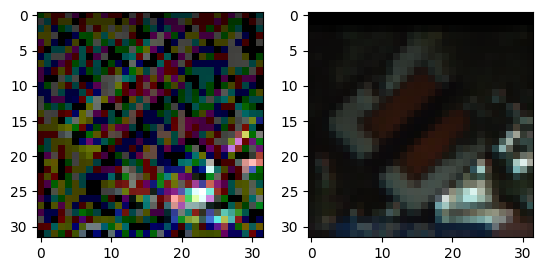

In [ ]:
from matplotlib import pyplot as plt
fig = plt.figure()
plt = fig.add_subplot(1,2,2)
plt.imshow(test_images[IMAGE_NUMBER], interpolation='nearest')
plt = fig.add_subplot(1,2,1)
plt.imshow(x_test_adv[0], interpolation='nearest')

Success! But image is very broken!

**What can we do?**

---



# Now it is your turn

- Select an attack (recommended: Square, SpatialTransformation, DeepFool, FGSM, CW; also AdversarialPatch, but it is a bit more complicated)

- Select an image (or more; but no more than 3-5 images)

- Apply the selected attack on the target image

- Try different configuration, to find the best tradeoff between attack efficacy and image alteration

- Measure image alteration with the L2 score! How? numpy.linalg. norm; sklearn.metrics.pairwise.euclidean_distances: many alternatives!

- Measure attack efficacy looking at the softmax outputs!

- Especially, try to reduce the L2.

- What is the corresponding trend of the softmax output? When does it stop being effective? Can you plot a curve L2 vs softmax?


Remeber the API are available at:

https://adversarial-robustness-toolbox.readthedocs.io/

And list of adversarial attacks at:

https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html

In [ ]:
from art.attacks.evasion import CarliniL2Method, CarliniLInfMethod
from matplotlib import pyplot as plt

images = [10, 20, 30]
x_images = np.asarray([test_images[i] for i in images])
classifier = KerasClassifier(model=model, clip_values=(0.0, 1.0))
confidence_grid = [0.0, 0.01, 0.1, 0.5, 1]
lr_grid = [0.1, 0.01, 0.005, 0.001, 0.0005]
NORM_L0 = 0
NORM_L2 = 1
NORM_LINF = 2

prob_L2 = np.zeros((len(images), len(confidence_grid), len(lr_grid)))
prob_LInf = np.zeros((len(images), len(confidence_grid), len(lr_grid)))

# 0: L0, 1:L2, 2:LInf
norms_L2 = np.zeros((3, len(images), len(confidence_grid), len(lr_grid)))
norms_LInf = np.zeros((3, len(images), len(confidence_grid), len(lr_grid)))

accuracy_L2 = np.zeros((len(confidence_grid), len(lr_grid)))
accuracy_LInf = np.zeros((len(confidence_grid), len(lr_grid)))

for n_conf, conf in enumerate(confidence_grid):
  for n_lr, lr in enumerate(lr_grid):
    attackL2 = CarliniL2Method(classifier=classifier, confidence=conf, learning_rate=lr)
    attackLInf = CarliniLInfMethod(classifier=classifier, confidence=conf, learning_rate=lr)

    # Perform the attack on the chosen images
    genByL2= attackL2.generate(x=x_images)
    genByLInf= attackLInf.generate(x=x_images)

    np.save(my_root_path+f'3-Adversarial Attacks/saves/CWL2/attacks-conf{conf}-lr{lr}.npy', genByL2)
    np.save(my_root_path+f'3-Adversarial Attacks/saves/CWLInf/attacks-conf{conf}-lr{lr}.npy', genByLInf)

    # Evaluate the ART classifier on adversarial test examples
    predL2 = classifier.predict(genByL2)
    predLInf = classifier.predict(genByLInf)

    # Save highest probability
    prob_L2[:, n_conf, n_lr] = np.max(predL2, axis=1)
    prob_LInf[:, n_conf, n_lr] = np.max(predLInf, axis=1)

    for n_img, img in enumerate(images):
      # CWL2
      norms_L2[NORM_L0, n_img, n_conf, n_lr] = np.linalg.norm(genByL2[n_img].flatten()-test_images[img].flatten(), ord=0)
      norms_L2[NORM_L2, n_img, n_conf, n_lr] = np.linalg.norm(genByL2[n_img].flatten()-test_images[img].flatten(), ord=2)
      norms_L2[NORM_LINF, n_img, n_conf, n_lr] = np.linalg.norm(genByL2[n_img].flatten()-test_images[img].flatten(), ord=np.inf)

      # CWLInf
      norms_LInf[NORM_L0, n_img, n_conf, n_lr] = np.linalg.norm(genByLInf[n_img].flatten()-test_images[img].flatten(), ord=0)
      norms_LInf[NORM_L2, n_img, n_conf, n_lr] = np.linalg.norm(genByLInf[n_img].flatten()-test_images[img].flatten(), ord=2)
      norms_LInf[NORM_LINF, n_img, n_conf, n_lr] = np.linalg.norm(genByLInf[n_img].flatten()-test_images[img].flatten(), ord=np.inf)

    # Plot the different images
    fig = plt.figure()
    for i, img in enumerate(images):
      _plt = fig.add_subplot(len(images),3,1+i*3)
      _plt.imshow(test_images[img], interpolation='nearest')
      if i==0: _plt.title.set_text("Original")

      _plt = fig.add_subplot(len(images),3,2+i*3)
      _plt.imshow(genByL2[i], interpolation='nearest')
      if i==0: _plt.title.set_text("CWL2")

      _plt = fig.add_subplot(len(images),3,3+i*3)
      _plt.imshow(genByLInf[i], interpolation='nearest')
      if i==0: _plt.title.set_text("CWLInf")

    accuracy_L2[n_conf, n_lr] = np.sum(np.argmax(predL2, axis=1) == [test_labels[img] for img in images]) / len(images)
    accuracy_LInf[n_conf, n_lr] = np.sum(np.argmax(predLInf, axis=1) == [test_labels[img] for img in images]) / len(images)

    fig.savefig(my_root_path+f'3-Adversarial Attacks/saves/conf{conf}-lr{lr}.png')

In [102]:
def norm_to_text(norm):
  if norm==NORM_L0:
    return "normL0"
  elif norm==NORM_L2:
    return "normL2"
  else:
    return "normLINF"

<ipython-input-103-f8982b437ffe>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+lr_grid)
<ipython-input-103-f8982b437ffe>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+confidence_grid)
<ipython-input-103-f8982b437ffe>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+lr_grid)
<ipython-input-103-f8982b437ffe>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+confidence_grid)


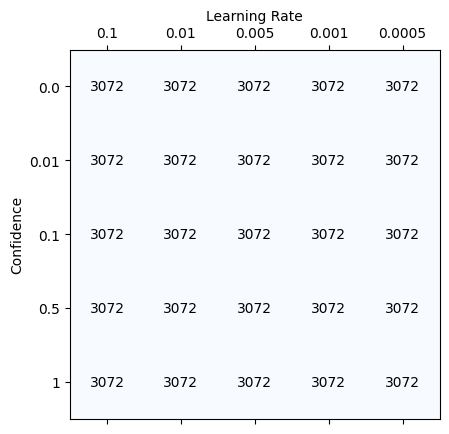

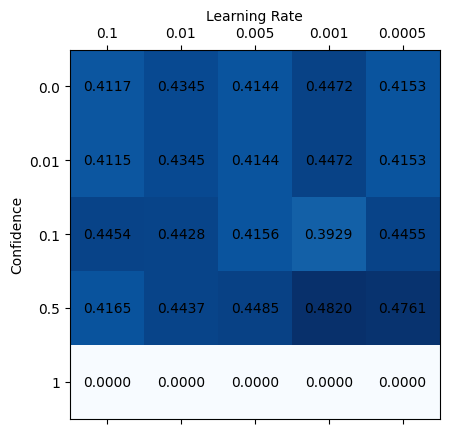

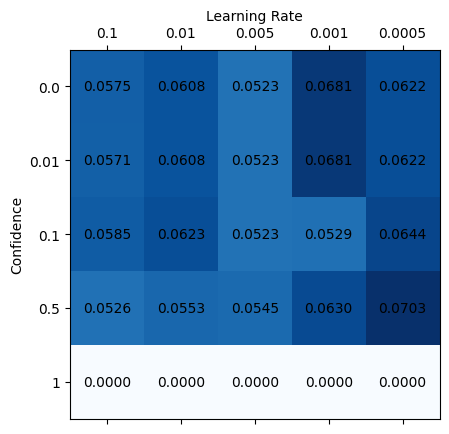

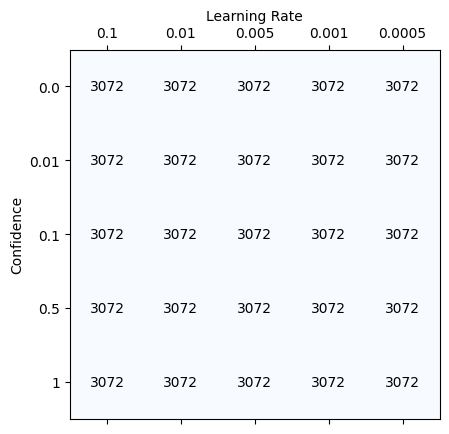

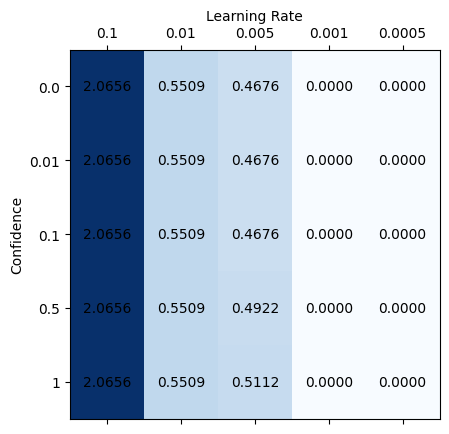

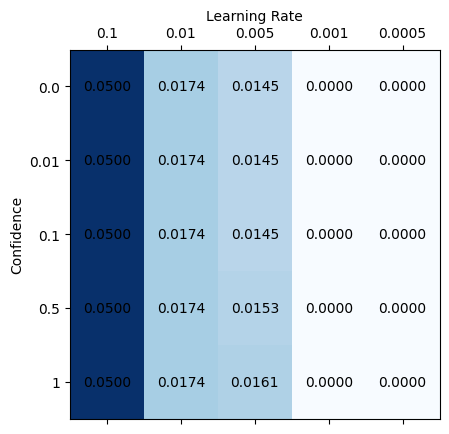

In [103]:
for norm in [NORM_L0, NORM_L2, NORM_LINF]:
  fig, ax = plt.subplots()
  to_format = "%d" if norm==NORM_L0 else "%.4f"

  to_plot = np.mean(norms_L2[norm], axis=0)
  ax.matshow(to_plot, cmap=plt.cm.Blues)
  ax.set_xticklabels(['']+lr_grid)
  ax.set_yticklabels(['']+confidence_grid)
  plt.xlabel("Learning Rate")
  plt.ylabel("Confidence")
  ax.xaxis.set_label_position('top')
  for i, conf in enumerate(confidence_grid):
      for j, lr in enumerate(lr_grid):
          c = to_plot[j,i]
          ax.text(i, j, to_format%c, va='center', ha='center')

  fig.savefig(my_root_path+f'3-Adversarial Attacks/saves/CWL2/{norm_to_text(norm)}.png')

###################################################################################################################################################

for norm in [NORM_L0, NORM_L2, NORM_LINF]:
  fig, ax = plt.subplots()
  to_format = "%d" if norm==NORM_L0 else "%.4f"

  to_plot = np.mean(norms_LInf[norm], axis=0)
  ax.matshow(to_plot, cmap=plt.cm.Blues)
  ax.set_xticklabels(['']+lr_grid)
  ax.set_yticklabels(['']+confidence_grid)
  plt.xlabel("Learning Rate")
  plt.ylabel("Confidence")
  ax.xaxis.set_label_position('top')
  for i, conf in enumerate(confidence_grid):
      for j, lr in enumerate(lr_grid):
          c = to_plot[j,i]
          ax.text(i, j, to_format%c, va='center', ha='center')

  fig.savefig(my_root_path+f'3-Adversarial Attacks/saves/CWLInf/{norm_to_text(norm)}.png')

<ipython-input-104-20c78fa4dbc1>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+lr_grid)
<ipython-input-104-20c78fa4dbc1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+confidence_grid)
<ipython-input-104-20c78fa4dbc1>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+lr_grid)
<ipython-input-104-20c78fa4dbc1>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+confidence_grid)


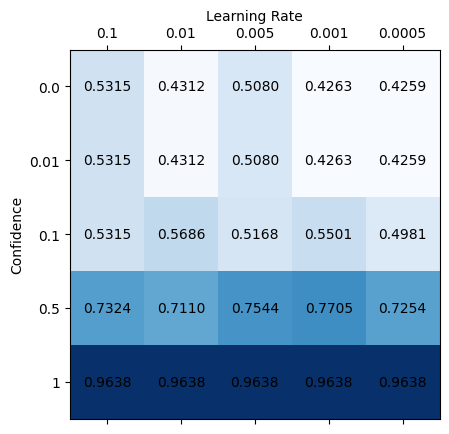

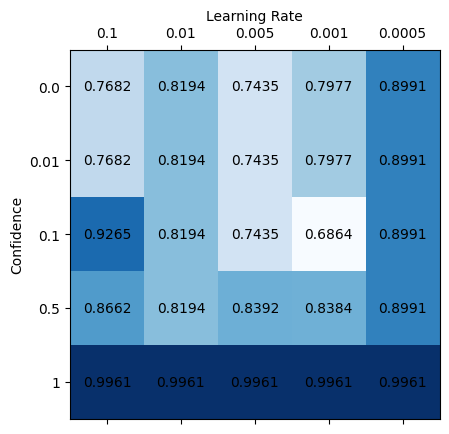

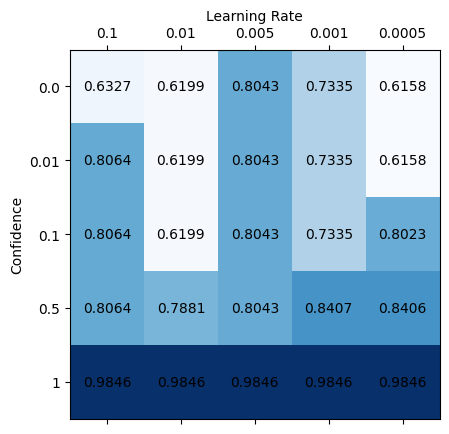

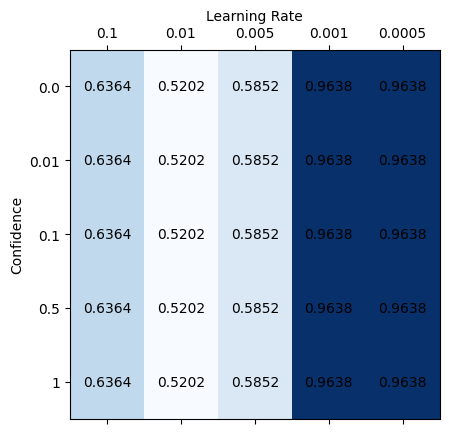

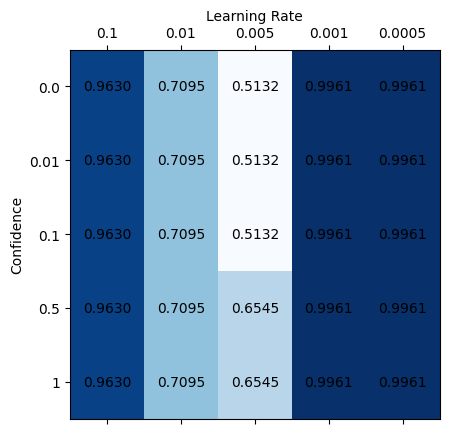

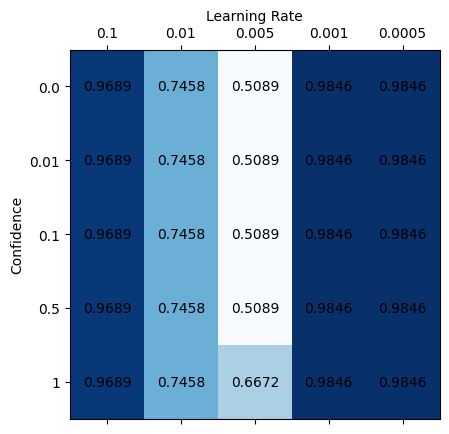

In [104]:
for k, img in enumerate(images):
  fig, ax = plt.subplots()

  to_plot = prob_L2[k]
  ax.matshow(to_plot, cmap=plt.cm.Blues)
  ax.set_xticklabels(['']+lr_grid)
  ax.set_yticklabels(['']+confidence_grid)
  plt.xlabel("Learning Rate")
  plt.ylabel("Confidence")
  ax.xaxis.set_label_position('top')
  for i, conf in enumerate(confidence_grid):
      for j, lr in enumerate(lr_grid):
          c = to_plot[j,i]
          ax.text(i, j, "%.4f"%c, va='center', ha='center')

  fig.savefig(my_root_path+f'3-Adversarial Attacks/saves/CWL2/prob_for_img_{str(img)}.png')

###################################################################################################################################################

for k, img in enumerate(images):
  fig, ax = plt.subplots()

  to_plot = prob_LInf[k]
  ax.matshow(to_plot, cmap=plt.cm.Blues)
  ax.set_xticklabels(['']+lr_grid)
  ax.set_yticklabels(['']+confidence_grid)
  plt.xlabel("Learning Rate")
  plt.ylabel("Confidence")
  ax.xaxis.set_label_position('top')
  for i, conf in enumerate(confidence_grid):
      for j, lr in enumerate(lr_grid):
          c = to_plot[j,i]
          ax.text(i, j, "%.4f"%c, va='center', ha='center')

  fig.savefig(my_root_path+f'3-Adversarial Attacks/saves/CWLInf/prob_for_img_{str(img)}.png')

<ipython-input-105-558a5c9137c1>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+lr_grid)
<ipython-input-105-558a5c9137c1>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+confidence_grid)
<ipython-input-105-558a5c9137c1>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+lr_grid)
<ipython-input-105-558a5c9137c1>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+confidence_grid)


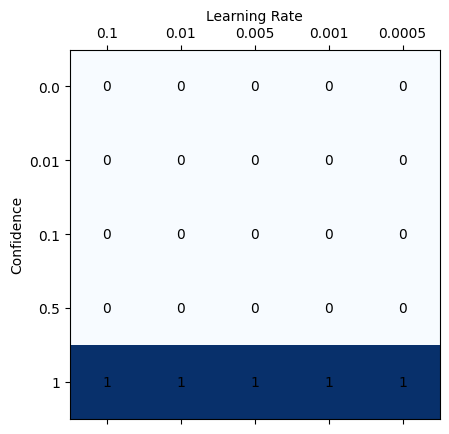

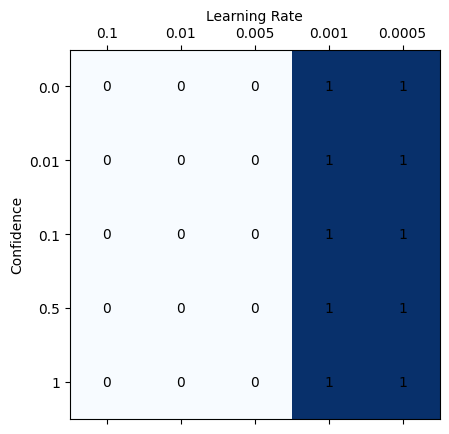

In [105]:
fig, ax = plt.subplots()

to_plot = accuracy_L2
ax.matshow(to_plot, cmap=plt.cm.Blues)
ax.set_xticklabels(['']+lr_grid)
ax.set_yticklabels(['']+confidence_grid)
plt.xlabel("Learning Rate")
plt.ylabel("Confidence")
ax.xaxis.set_label_position('top')
for i, conf in enumerate(confidence_grid):
    for j, lr in enumerate(lr_grid):
        c = to_plot[j,i]
        ax.text(i, j, "%d"%c, va='center', ha='center')

fig.savefig(my_root_path+f'3-Adversarial Attacks/saves/CWL2/accuracy.png')

###################################################################################################################################################

fig, ax = plt.subplots()

to_plot = accuracy_LInf
ax.matshow(to_plot, cmap=plt.cm.Blues)
ax.set_xticklabels(['']+lr_grid)
ax.set_yticklabels(['']+confidence_grid)
plt.xlabel("Learning Rate")
plt.ylabel("Confidence")
ax.xaxis.set_label_position('top')
for i, conf in enumerate(confidence_grid):
    for j, lr in enumerate(lr_grid):
        c = to_plot[j,i]
        ax.text(i, j, "%d"%c, va='center', ha='center')

fig.savefig(my_root_path+f'3-Adversarial Attacks/saves/CWLInf/accuracy.png')